In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import arviz as az
from matplotlib import pyplot as plt

1) Reproduce the right part of Fig. 9.15 (leading to the decision in the third paragraph of Section 12.1.2 - use that paragraph to see whether your plots make sense)


In [2]:
data = pd.read_csv('BattingAverage.csv')
n_categories = len(data.PriPosNumber.unique())
n_players = len(data)
positions = data.PriPosNumber.to_numpy() -1

In [3]:
def name_rownum(name):
    row_number = data[ (data.Player == name) ].index 
    return row_number

In [4]:
with pm.Model() as model:
    # the top-level prior (Hyper-parameters)
    omega = pm.Beta ("omega", 1,1)
    kappa = pm.Deterministic(
        "kappa", 
        pm.Gamma ("kappa_minus_2", 0.01, 0.01) + 2
    )
    
    # paramaters for primary field positions
    omega_c = pm.Beta (
        "omega_c",
        omega * (kappa-2) +1, 
        (1-omega)*(kappa-2) +1, 
        shape=n_categories
    )
    
    kappa_c = pm.Deterministic (
        "kappa_c",
        pm.Gamma ("kappa_c_minus_2", 0.01, 0.01, shape=n_categories) + 2
    )
    
    # parameters for individual player 
    theta = pm.Beta('theta',
                     omega_c[positions]*(kappa_c[positions]-2)+1,
                    (1-omega_c[positions])*(kappa_c[positions]-2)+1,
                     shape = n_players)
    
    # We are using the same "speed-up" trick as Kruschke is doing, 
    # modeling experiences of each player as a Binomial distribution.
    # Note that above we have produced the theta vector in the same 
    # order as the players in the file, so the observed data in the 
    # binomial distribution will be applied correctly, per each of the 
    # variables in the vector.  It seems that because theta is a vector, 
    # the entire y variable is automatically vectorized.
    
    # Likelihood function
    y = pm.Binomial (
        'y', 
        n = data.AtBats.values, 
        p=theta, 
        observed=data.Hits,
        shape=n_players)
    
    Shi_minus_Ich = pm.Deterministic (
            "Shi_minus_Ich", 
            theta[[name_rownum('ShinSoo Choo')]] - theta[[name_rownum('Ichiro Suzuki')]]
        )

In [5]:
with model:
    trace = pm.sample (5000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, kappa_c_minus_2, omega_c, kappa_minus_2, omega]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [03:10<00:00, 115.40draws/s]
The number of effective samples is smaller than 10% for some parameters.


/home/neutron/anaconda3/envs/PP/lib/python3.8/site-packages/arviz/data/base.py:140: SyntaxWarning: More chains (20000) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
/home/neutron/anaconda3/envs/PP/lib/python3.8/site-packages/arviz/data/base.py:140: SyntaxWarning: More chains (20000) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
/home/neutron/anaconda3/envs/PP/lib/python3.8/site-packages/arviz/data/base.py:140: SyntaxWarning: More chains (20000) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
/home/neutron/anaconda3/envs/PP/lib/python3.8/site-packages/arviz/data/base.py:140: SyntaxWarning: More chains (20000) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
/home/neutron/anaconda3/envs/PP/lib/python3.8/site-packages/arviz/data/base.py:140: SyntaxWarning: More chains (20000) than draws (1). Passed array should have shape (chain

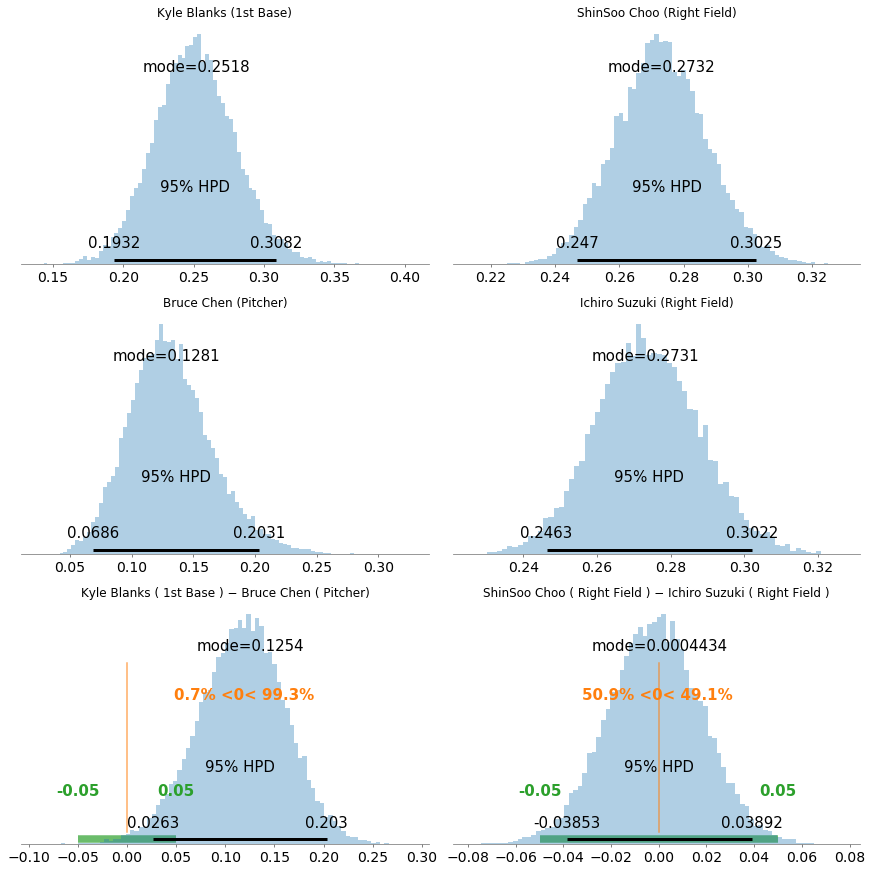

In [6]:
from matplotlib import gridspec
fig3 = plt.figure(constrained_layout=True, figsize=(12,12))
gs = fig3.add_gridspec(3, 6)
f3_ax1 = fig3.add_subplot(gs[0, :3])
f3_ax2 = fig3.add_subplot(gs[0, 3:])
f3_ax3 = fig3.add_subplot(gs[1, :3])
f3_ax4 = fig3.add_subplot(gs[1, 3:])
f3_ax5 = fig3.add_subplot(gs[2, :3])
f3_ax6 = fig3.add_subplot(gs[2, 3:])

pm.plot_posterior(
    trace['theta'][:, name_rownum('ShinSoo Choo')], ax=f3_ax2, point_estimate='mode', round_to=4, 
    credible_interval=0.95, kind='hist'
)
f3_ax2.set_title("ShinSoo Choo (Right Field)")

pm.plot_posterior(
    trace['theta'][:, name_rownum('Ichiro Suzuki')], ax=f3_ax4, point_estimate='mode', round_to=4, 
    credible_interval=0.95, kind='hist'
)
f3_ax4.set_title("Ichiro Suzuki (Right Field)")

pm.plot_posterior(
        trace['Shi_minus_Ich'], ax=f3_ax6, point_estimate='mode', round_to=4,
        credible_interval=0.95, kind='hist', ref_val=0.0, rope=(-0.05,+0.05)
    )
f3_ax6.set_title("ShinSoo Choo ( Right Field ) − Ichiro Suzuki ( Right Field )")


pm.plot_posterior(
    trace['theta'][:, name_rownum('Kyle Blanks')], ax=f3_ax1, point_estimate='mode', round_to=4, 
    credible_interval=0.95, kind='hist'
)
f3_ax1.set_title("Kyle Blanks (1st Base)")

pm.plot_posterior(
    trace['theta'][:, name_rownum('Bruce Chen')], ax=f3_ax3, point_estimate='mode', round_to=4, 
    credible_interval=0.95, kind='hist'
)
f3_ax3.set_title("Bruce Chen (Pitcher)")


pm.plot_posterior( trace['theta'][:, name_rownum('Kyle Blanks')] - trace['theta'][:, name_rownum('Bruce Chen')],
         ax=f3_ax5, point_estimate='mode',  round_to=4,
        credible_interval=0.95, kind='hist', ref_val=0.0, rope=(-0.05,+0.05)
    )
f3_ax5.set_title("Kyle Blanks ( 1st Base ) − Bruce Chen ( Pitcher)");

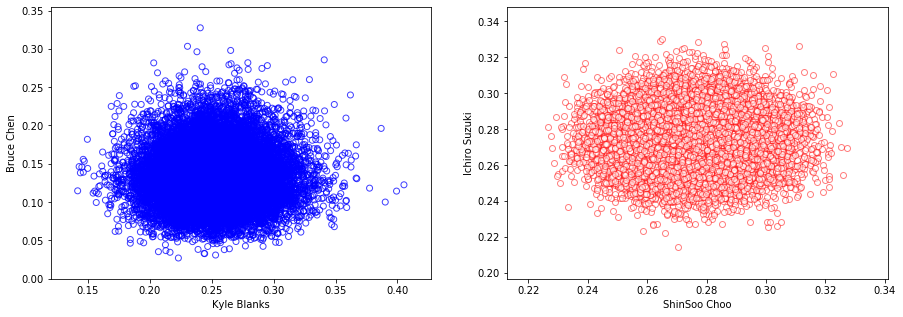

In [7]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].scatter(trace['theta'][:, name_rownum('Kyle Blanks')], trace['theta'][:, name_rownum('Bruce Chen')], 
            alpha=0.75, color='blue', facecolor='none')
ax[0].set_xlabel("Kyle Blanks")
ax[0].set_ylabel("Bruce Chen")


ax[1].scatter(trace['theta'][:, name_rownum('Ichiro Suzuki')], trace['theta'][:, name_rownum('ShinSoo Choo')],
            alpha=0.50, color='red', facecolor='white')
ax[1].set_xlabel("ShinSoo Choo")
ax[1].set_ylabel("Ichiro Suzuki");

2. Attempt to regenerate Figures 12.1 from the book following these steps: 
* Generate a random sample of $\theta_1$ using a normal distribution with mode 0.58 and $\theta_2 = Normal(\theta_1, 0.08)$ 
* Explain why the above parameters have been selected for the generator
* Plot the four figures from the sample

   One way to do the above fairly fast is to build a pymc3 model without observation data and sample from this one (as if we sampled from the prior).

In [8]:
with pm.Model() as model_left:
    mode = 0.58
    θ1 = pm.Normal('θ1', mu=mode, sd=0.08)
    
    θ2 = pm.Normal('θ2', θ1, 0.08)  
    
    θ1_minus_θ2 = pm.Deterministic (
            "θ1_minus_θ2", 
            θ1 - θ2
        )   

In [9]:
with model_left:
    trace_left = pm.sample (1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ2, θ1]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:03<00:00, 1600.07draws/s]


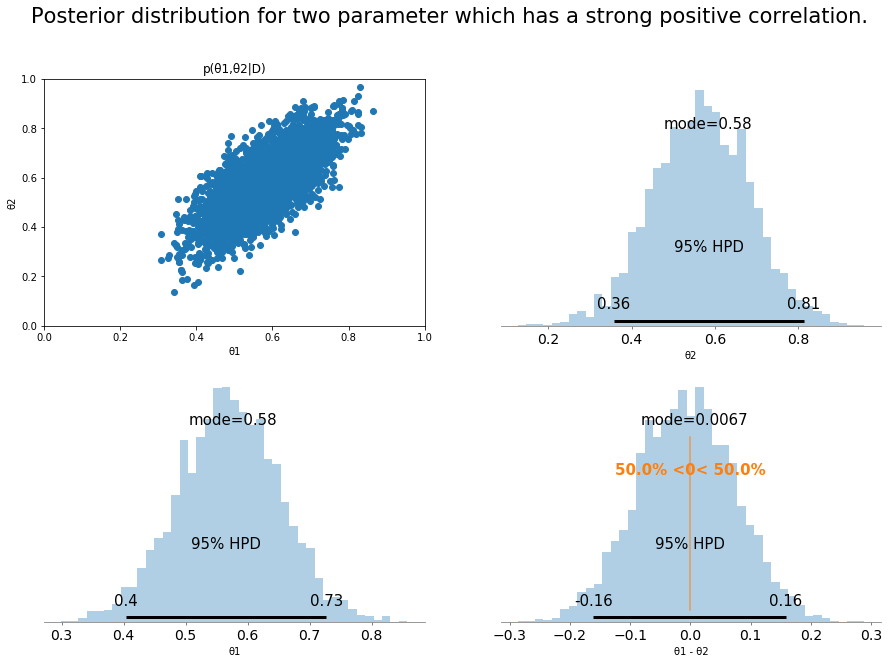

In [10]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
fig.suptitle('Posterior distribution for two parameter which has a strong positive correlation.', fontsize='21')

ax[0,0].scatter(trace_left['θ1'], trace_left['θ2'])
ax[0,0].set_xlim(0,1)
ax[0,0].set_ylim(0,1)

pm.plot_posterior(trace_left['θ2'], ax=ax[0,1], kind='hist', point_estimate='mode', credible_interval=0.95)
pm.plot_posterior(trace_left['θ1'], ax=ax[1,0], kind='hist', point_estimate='mode', credible_interval=0.95)
pm.plot_posterior(trace_left['θ1_minus_θ2'], ax=ax[1,1], kind='hist', point_estimate='mode', 
                  credible_interval=0.95, ref_val=0.0)

ax[0,0].set_title("p(θ1,θ2|D)")
ax[0,1].set_title("")
ax[1,0].set_title("")
ax[1,1].set_title("")

ax[0,0].set_xlabel("θ1")
ax[0,0].set_ylabel("θ2")

ax[0,1].set_xlabel("θ2")
ax[1,0].set_xlabel("θ1")
ax[1,1].set_xlabel("θ1 - θ2");

3. Repeat the exercise with a different generator of the sample, to reproduce the second part of the figure:
* Generate a random sample of $\theta_1$ with mode 0.58 as above and $\theta_2 = Normal(1 - \theta_1, 0.08)$ 
* ...

In [11]:
with pm.Model() as model_right:
    mode = 0.58
    θ1 = pm.Normal ("θ1", mu=mode, sd=0.08)
    
    θ2 = pm.Normal('θ2', 1-θ1, 0.08)  
    
    θ1_minus_θ2 = pm.Deterministic (
            "θ1_minus_θ2", 
            θ1 - θ2
        )   

In [12]:
with model_right:
    trace_right = pm.sample (1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ2, θ1]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:03<00:00, 1538.43draws/s]
The acceptance probability does not match the target. It is 0.8804688434249783, but should be close to 0.8. Try to increase the number of tuning steps.


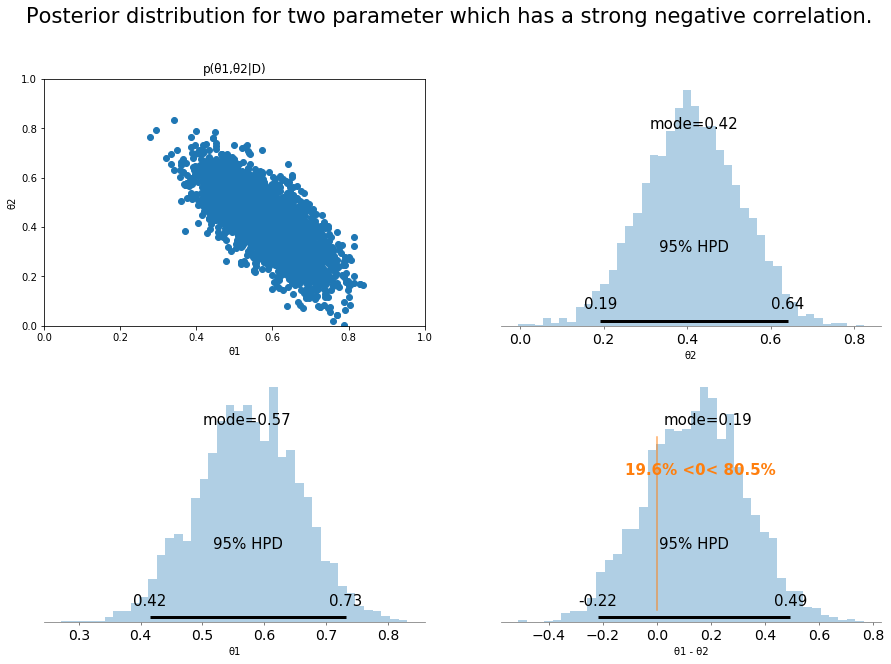

In [13]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
fig.suptitle('Posterior distribution for two parameter which has a strong negative correlation.', fontsize='21')


ax[0,0].scatter(trace_right['θ1'], trace_right['θ2'])
ax[0,0].set_xlim(0,1)
ax[0,0].set_ylim(0,1)

pm.plot_posterior(trace_right['θ2'], ax=ax[0,1], kind='hist', point_estimate='mode', credible_interval=0.95)
pm.plot_posterior(trace_right['θ1'], ax=ax[1,0], kind='hist', point_estimate='mode', credible_interval=0.95)
pm.plot_posterior(trace_right['θ1_minus_θ2'], ax=ax[1,1], kind='hist', point_estimate='mode', 
                  credible_interval=0.95, ref_val=0.0)

ax[0,0].set_title("p(θ1,θ2|D)")
ax[0,1].set_title("")
ax[1,0].set_title("")
ax[1,1].set_title("")

ax[0,0].set_xlabel("θ1")
ax[0,0].set_ylabel("θ2")

ax[0,1].set_xlabel("θ2")
ax[1,0].set_xlabel("θ1")
ax[1,1].set_xlabel("θ1 - θ2");

4. Repeat the exercises 2-3 but now save your sample in a file (or a variable) and use it as data for another model with a weak prior. Use the inference to estimate the posteriors and replot the same plots.  It is interesting to compare the HDI endpoints between 1/2 and 3.

   Note that posterior_plot (search in: https://docs.pymc.io/api/plots.html) takes the 'rope' as a parameter, so we can even add some simple (fake) ROPEs to the above plots. I recommend that you try that.

In [14]:
pm.save_trace(trace_right, "saved_trace_right")

'saved_trace_right'

In [15]:
MR = pm.load_trace('saved_trace_right', model=model_right)

In [16]:
Data = MR.get_values('θ1')

with pm.Model() as model_weak_prior:
    theta = pm.Beta(name="theta1", alpha=1, beta=1)
    y = pm.Bernoulli(name="obs", p=theta, observed=Data) # likelihood

In [17]:
with model_weak_prior:
    trace_weak_prior = pm.sample (1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [03:33<00:00, 28.10draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


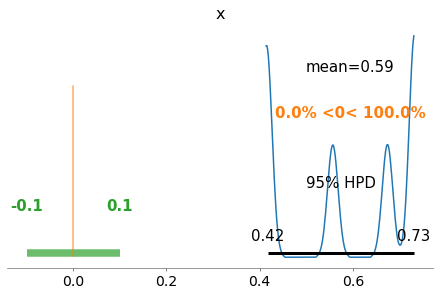

In [18]:
pm.plot_posterior(trace_weak_prior[theta], credible_interval=0.95, ref_val=0.0,rope=(-0.1, 0.1));